In [1]:
import sys

sys.path.append('C:/Users/vadub/YandexDisk/Исследования РКЦ/Quantum Key Distribution/')

In [2]:
import time
import numpy as np

from joblib import Parallel, delayed

In [3]:
from qkd_networks_signal_distribution.one_path.problem_generator import generate_problem
from qkd_networks_signal_distribution.one_path.greedy_solution import greedy_solution

In [4]:
nodes_count = 30
edges_to_nodes_ratios = [1, 1.5, 2, 3, 5, 8, 13]
pathes_count_constant = 20

repeat_iterations_count = 200
one_path_flows = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]

In [4]:
# nodes_count = 10
# edges_to_nodes_ratios = [1, 1.5]
# pathes_count_constant = 1

# repeat_iterations_count = 20
# one_path_flows = [32, 64, 128]

In [5]:
start_time = time.time()

generated_problems = []

for edges_to_nodes_ratio in edges_to_nodes_ratios:
    print("Generate graphs for edges_to_nodes_ratio = {0}".format(edges_to_nodes_ratio))
    generated_problems.append(Parallel(n_jobs=-1)(
        delayed(generate_problem)(
            nodes_count, edges_to_nodes_ratio, pathes_count_constant, seed + 234234
        )
        for seed in range(repeat_iterations_count)
    ))
    
print("All problems are generated with time:", time.time() - start_time)

Generate graphs for edges_to_nodes_ratio = 1
Generate graphs for edges_to_nodes_ratio = 1.5
Generate graphs for edges_to_nodes_ratio = 2
Generate graphs for edges_to_nodes_ratio = 3
Generate graphs for edges_to_nodes_ratio = 5
Generate graphs for edges_to_nodes_ratio = 8
Generate graphs for edges_to_nodes_ratio = 13
All problems are generated with time: 11559.21037197113


In [6]:
all_graphs = []
all_goals = []

for problems in generated_problems:
    graphs, goals, _ = list(zip(*problems))
    all_graphs.append(graphs)
    all_goals.append(goals)

In [7]:
np.shape(all_goals)

(7, 200, 30, 30)

In [8]:
cpu_cores = 8

In [9]:
from typing import List, Tuple


def binary_search_with_linear_programming_solution(graph, goal) -> Tuple[np.ndarray, List[Tuple[str, str]]]:
    left_border = 0
    right_border = np.amax(goal)
    while right_border - left_border > 1e-5:
        middle = (left_border + right_border) / 2
        linear_flow, flow_edges = linear_programming_solution(graph, np.maximum(0, goal - middle))
        linear_resulted_flow = check_solution(graph, goal, linear_flow, flow_edges)
        if np.amax(goal - linear_resulted_flow) < 1e-6:
            right_border = middle
        else:
            left_border = middle
    return linear_programming_solution(graph, np.maximum(0, goal - right_border))

In [ ]:
all_greedy_results = []
mean_greedy_time = []
mean_linear_programming_time = []

for idx, problems in enumerate(generated_problems):
    print("Solve problem for nodes_count={0}, edges_to_nodes_ratio={1}, pathes_count={2}".format(
        nodes_count, edges_to_nodes_ratios[idx], pathes_count_constant))
# problems = generated_problems[-1]
    for path_flow_idx, one_path_flow in enumerate(one_path_flows):
        print("Current one path flow:", one_path_flow)
        error_sum = 0
        generation_time_sum = 0
        linear_time_sum = 0
        greedy_time_sum = 0

        minimal_error = 1
        maximal_error = 0

#         start_time = time.time()
#         linear_solution_result = Parallel(n_jobs=-1)(
#             delayed(binary_search_with_linear_programming_solution)(
#                 graph, goal
#             )
#             for graph, goal in problems
#         )
#         print("Linear solution calculated with time:", time.time() - start_time)
#         mean_linear_programming_time.append((time.time() - start_time) * cpu_cores / repeat_iterations_count)

#         start_time = time.time()
#         all_linear_resulted_flows = Parallel(n_jobs=-1)(
#             delayed(check_solution)(
#                 graph, goal, linear_flow, flow_edges
#             )
#             for (graph, goal), (linear_flow, flow_edges) in zip(problems, linear_solution_result)
#         )
#         print("Linear solution checked with time:", time.time() - start_time)


        start_time = time.time()
        greedy_solution_results = Parallel(n_jobs=-1)(
            delayed(greedy_solution)(
                graph, goal, one_path_flow
            )
            for graph, goal, _ in problems
        )
        print("Greedy solution calculated with time:", time.time() - start_time)
        mean_greedy_time.append(((time.time() - start_time) * cpu_cores / repeat_iterations_count))

#         start_time = time.time()
#         all_greedy_resulted_flows = Parallel(n_jobs=-1)(
#             delayed(check_solution)(
#                 graph, goal, linear_flow, flow_edges
#             )
#             for (graph, goal), (linear_flow, flow_edges) in zip(problems, greedy_solution_result)
#         )
#         print("Greedy solution checked with time:", time.time() - start_time)

        all_greedy_results.append(np.array([greedy_solution_result[1] for greedy_solution_result in greedy_solution_results]))

Solve problem for nodes_count=30, edges_to_nodes_ratio=1, pathes_count=20
Current one path flow: 0.125


In [ ]:
print(mean_greedy_time)

In [ ]:
print(mean_greedy_time)

In [ ]:
print(mean_linear_programming_time)

In [ ]:
np.shape(all_greedy_results)

In [ ]:
np.shape(all_greedy_results)

In [ ]:
# f = open("greedy_results_0.125_128_edges_to_nodes_1_1.5_2_3_5_8_13", 'w')
# f.write(str(all_greedy_results))
# f.close()

In [ ]:
mean_linear_programming_time

In [ ]:
np.shape(all_greedy_results)

In [ ]:
np.shape(all_goals)

In [ ]:
all_greedy_results = np.reshape(all_greedy_results, (len(edges_to_nodes_ratios), len(one_path_flows), repeat_iterations_count, nodes_count, nodes_count))

In [ ]:
all_greedy_results.shape

In [ ]:
mean_errors = []

for edge_idx, edge_to_node_ratio in enumerate(edges_to_nodes_ratios):
    for flow_idx, one_path_flow in enumerate(one_path_flows):
        print("Current one path flow:", one_path_flow)
        mean_error = 0
        for i in range(repeat_iterations_count):
            if np.amax(all_goals[edge_idx][i] - all_greedy_results[edge_idx][flow_idx][i]) > 1e-2:
                # print("Iteration {0}: {1}".format(i, np.amax(all_goals[edge_idx][i] - all_greedy_results[edge_idx][flow_idx][i])))
                mean_error += np.amax(all_goals[edge_idx][i] - all_greedy_results[edge_idx][flow_idx][i]) / np.amax(all_goals[edge_idx][i])
        print("Mean error:", mean_error / repeat_iterations_count)
        mean_errors.append(mean_error / repeat_iterations_count)

In [ ]:
mean_errors = np.reshape(mean_errors, (len(edges_to_nodes_ratios), len(one_path_flows)))

In [ ]:
mean_errors

In [ ]:
mean_errors = mean_errors.T

In [ ]:
import matplotlib.pyplot as plt


# for idx in range(len(edges_to_nodes_ratios)):
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(2, 1, 1)
ax.set_title("График относительной ошибки для сети с 30 агентами")
ax.set_xticks(np.arange(11), minor=False)
ax.set_xticklabels(map(str, one_path_flows))
ax.grid()
ax.plot(range(len(mean_errors)), mean_errors)
ax.set_xlabel('Размер шага алгоритма - signal_size')
ax.legend(["Количество связей в сети = {0}".format(int(edges_to_nodes_ratios[i] * nodes_count + 0.5)) for i in range(len(edges_to_nodes_ratios))])
ax.set_ylabel('Средняя относительная ошибка')
plt.show()

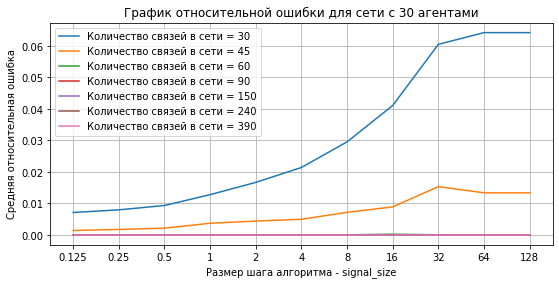

In [22]:
import matplotlib.pyplot as plt


# for idx in range(len(edges_to_nodes_ratios)):
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(2, 1, 1)
ax.set_title("График относительной ошибки для сети с 30 агентами")
ax.set_xticks(np.arange(11), minor=False)
ax.set_xticklabels(map(str, one_path_flows))
ax.grid()
ax.plot(range(len(mean_errors)), mean_errors)
ax.set_xlabel('Размер шага алгоритма - signal_size')
ax.legend(["Количество связей в сети = {0}".format(int(edges_to_nodes_ratios[i] * nodes_count + 0.5)) for i in range(len(edges_to_nodes_ratios))])
ax.set_ylabel('Средняя относительная ошибка')
plt.show()

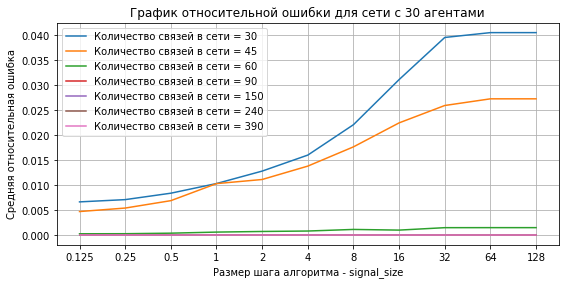

In [135]:
# for idx in range(len(edges_to_nodes_ratios)):
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(2, 1, 1)
ax.set_title("График относительной ошибки для сети с 30 агентами")
ax.set_xticks(np.arange(11), minor=False)
ax.set_xticklabels(map(str, one_path_flows))
ax.grid()
ax.plot(range(len(mean_errors)), mean_errors)
ax.set_xlabel('Размер шага алгоритма - signal_size')
ax.legend(["Количество связей в сети = {0}".format(int(edges_to_nodes_ratios[i] * nodes_count + 0.5)) for i in range(len(edges_to_nodes_ratios))])
ax.set_ylabel('Средняя относительная ошибка')
plt.show()

In [98]:
mean_greedy_time = np.reshape(mean_greedy_time, (len(edges_to_nodes_ratios), len(one_path_flows)))

In [116]:
mean_greedy_time = mean_greedy_time.T

In [118]:
mean_linear_programming_time

[4.38933353940979,
 4.36556508100979,
 4.37898850440979,
 4.3813090133667,
 4.379908714294434,
 4.417437219619751,
 4.383629522323608,
 4.397432689666748,
 4.387350330352783,
 4.386990299224854,
 4.391111164093018,
 5.339645347595215,
 5.361050128936768,
 5.3386051464080815,
 5.3775739574432375,
 5.343966341018676,
 5.340765581130982,
 5.333884067535401,
 5.339285268783569,
 5.333844079971313,
 5.343126134872437,
 5.338645124435425,
 6.29786093711853,
 6.2919003295898435,
 6.309896812438965,
 6.299502067565918,
 6.291140193939209,
 6.292260360717774,
 6.290580005645752,
 6.291940298080444,
 6.292220344543457,
 6.299702081680298,
 6.307461814880371,
 8.16028205871582,
 8.160042009353639,
 8.157801570892333,
 8.171524620056152,
 8.16140230178833,
 8.158161640167236,
 8.192449312210083,
 8.159201793670654,
 8.164162950515747,
 8.156881380081177,
 8.16464303970337,
 11.872720184326171,
 11.868879222869873,
 11.880761957168579,
 12.107205877304077,
 12.387243566513062,
 12.395410585403443,


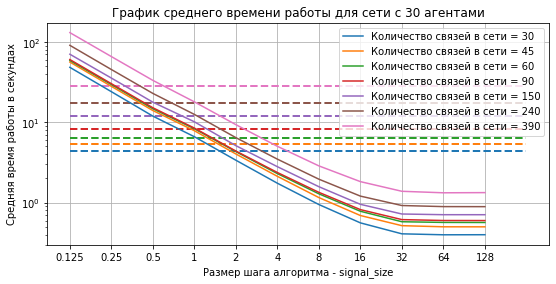

In [136]:
# for idx in range(len(edges_to_nodes_ratios)):
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(2, 1, 1)
ax.set_title("График среднего времени работы для сети с 30 агентами")
ax.set_xticks(np.arange(11), minor=False)
ax.set_xticklabels(map(str, one_path_flows))
ax.grid()
ax.plot(range(len(mean_greedy_time)), mean_greedy_time)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
for idx, lp_time in enumerate(mean_linear_programming_time[::11]):
    ax.hlines(y=lp_time, xmin=0, xmax=11, linewidth=2, color=colors[idx], linestyle='--')

ax.set_yscale('log')
ax.set_xlabel('Размер шага алгоритма - signal_size')
ax.legend(["Количество связей в сети = {0}".format(int(edges_to_nodes_ratios[i] * nodes_count + 0.5)) for i in range(len(edges_to_nodes_ratios))])
ax.set_ylabel('Средняя время работы в секундах')
plt.show()

In [ ]:
# for idx in range(len(edges_to_nodes_ratios)):
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(2, 1, 1)
ax.set_xticks(np.arange(11), minor=False)
ax.set_xticklabels(map(str, one_path_flows))
ax.grid()
ax.plot(range(len(mean_errors)), mean_errors)
ax.set_xlabel('Signal_size')
ax.legend(["edges_count={0}".format(int(edges_to_nodes_ratios[i] * nodes_count + 0.5)) for i in range(len(edges_to_nodes_ratios))])
ax.set_ylabel('Mean relative error')
plt.show()

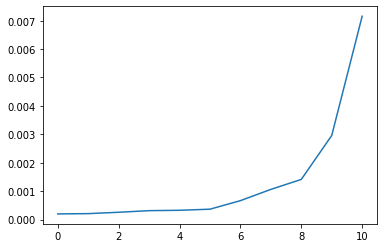

In [44]:
plt.plot(range(len(mean_errors)), mean_errors)

In [28]:
#open and read the file after the appending:
f = open("200_iterations_0.125_to_128_with_seed_234234", "w")
f.write(str(all_greedy_results_final))

31995582

In [29]:
f.close()

In [ ]:
mean_errors = []
maximal_errors = []
minimal_errors = []

all_errors = []
all_goals = []

In [20]:
np.sum(all_errors[97])

8.00000193218399

In [11]:
np.amax(all_errors[200:400], axis=(1, 2))

array([9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 6.10947936e-07,
       9.32253919e-07, 7.70361922e-07, 9.53674316e-07, 9.08970875e-07,
       6.55651377e-07, 9.53674316e-07, 8.34465027e-07, 5.57355811e-07,
       9.53674316e-07, 9.08970875e-07, 9.53674316e-07, 9.53674316e-07,
       6.55651377e-07, 7.15255965e-07, 9.50880349e-07, 9.20824057e-07,
       4.42777377e-07, 6.55651377e-07, 9.53674316e-07, 9.53674316e-07,
       9.53674316e-07, 4.73910148e-07, 6.25849083e-07, 9.53674316e-07,
       7.89761700e-07, 9.35047879e-07, 9.53674316e-07, 7.48783350e-07,
       5.82687143e-07, 9.53674316e-07, 7.89761700e-07, 7.37607678e-07,
       3.42726707e-07, 9.53674316e-07, 9.01520302e-07, 8.11436095e-07,
       9.10255459e-07, 9.53674316e-07, 6.25849083e-07, 9.35979202e-07,
       9.53674316e-07, 4.76837613e-07, 5.51262360e-07, 9.23872022e-07,
       3.26284052e-07, 4.76837613e-07, 9.53674316e-07, 9.53674316e-07,
       4.76837613e-07, 9.53674316e-07, 3.57628423e-07, 7.15255965e-07,
      

In [23]:
all_errors[-41]

array([[0.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ],
       [0.        , 0.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ],
       [0.        , 0.        , 0.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.

In [10]:
mean_errors

NameError: name 'mean_errors' is not defined

In [12]:
len(np.nonzero(all_errors[22])[0])

52

In [10]:
1 / np.sum(np.amax(all_goals, axis=(1, 2)))

0.00046707146193367583

In [31]:
np.where([i > 1e-4 for i in np.amax(all_errors, axis=(1, 2))])

(array([ 22,  72, 122, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
        186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
        199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
        212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
        225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
        238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249],
       dtype=int64),)

In [42]:
np.amax(all_errors, axis=(1, 2))

array([9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07,
       9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07,
       9.53674316e-07, 5.36443395e-07, 7.15256647e-07, 9.53674316e-07,
       9.53674316e-07, 7.15256647e-07, 9.53674316e-07, 9.53674316e-07,
       7.07805157e-07, 9.53674316e-07, 9.53674316e-07, 3.87430191e-07,
       8.34465482e-07, 7.15256647e-07, 2.50000000e-01, 9.53674316e-07,
       6.81633626e-07, 9.53674316e-07, 7.15256647e-07, 6.55652229e-07,
       9.38773212e-07, 9.53674316e-07, 9.53674316e-07, 8.94069899e-07,
       9.53674316e-07, 9.53674316e-07, 8.34465482e-07, 9.53674316e-07,
       9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07,
       7.01348949e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07,
       5.56311458e-07, 5.86876524e-07, 9.53674316e-07, 9.53674316e-07,
       9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07,
       9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07,
      

In [33]:
np.amax(all_errors[150:200], axis=(1, 2))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [16]:
x, y = np.nonzero(all_errors[22])

In [20]:
len(np.nonzero(all_goals[22])[0])

169

In [17]:
all_errors[22][x, y]

array([7.07805157e-07, 2.31045615e-07, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 2.50000000e-01,
      

In [41]:
all_errors[172]

array([[ 0.00000000e+00, -1.00000000e+00,  0.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.00000000e+00,  0.00000000e+00, -1.00000000e+00,
        -1.00000000e+00,  0.00000000e+00, -1.00000000e+00,
         0.00000000e+00, -9.99999329e-01,  0.00000000e+00,
        -1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
         0.00000000e+00, -1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.00000000e+00,  7.62208462e-07, -1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.00000000e+00,  0.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.0

In [25]:
np.sum(all_errors[200:250], axis=(1, 2))

array([9.53674316e-07, 9.53674341e-07, 9.53674316e-07, 5.10000007e+01,
       9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07,
       9.53674316e-07, 1.80000002e+01, 9.53674316e-07, 9.53674316e-07,
       9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07,
       9.53674473e-07, 9.53674316e-07, 9.53674316e-07, 7.15255737e-07,
       9.53674316e-07, 7.15255737e-07, 2.00000048e+00, 9.53674316e-07,
       9.53674316e-07, 9.53674316e-07, 7.15255737e-07, 3.30000002e+01,
       6.70000001e+01, 9.53674316e-07, 9.53674316e-07, 3.00000018e+00,
       9.53674316e-07, 9.53674316e-07, 9.53674316e-07, 7.15255737e-07,
       7.15255894e-07, 7.15255737e-07, 7.15255737e-07, 9.53674544e-07,
       4.10000007e+01, 7.15255737e-07, 9.53674316e-07, 9.53674316e-07,
       7.15255737e-07, 9.53674316e-07, 9.53674316e-07, 9.53674316e-07,
       9.53674316e-07, 9.53674316e-07])

In [13]:
x, y = np.nonzero(all_errors[0])

In [17]:
len(x)

92

In [16]:
all_errors[0][x, y]

array([4.54485416e-07, 5.51489059e-08, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
      

In [10]:
seed = 0

In [11]:
graph, goal = generate_problem(nodes_count, edges_to_nodes_ratio, pathes_count_constant, seed)

linear_flow, flow_edges = linear_programming_solution(graph, goal)
linear_resulted_flow = check_solution(graph, goal, linear_flow, flow_edges)
assert np.amax(goal - linear_resulted_flow) < 1e-6, "Error: linear solver didn't find an optimal solution"
        
greedy_flow, flow_edges = greedy_solution(graph, goal, 4.0)
greedy_resulted_flow = check_solution(graph, goal, greedy_flow, flow_edges)

All flow checks are successful
All flow checks are successful


In [13]:
print(np.amax(goal - greedy_resulted_flow) / np.amax(goal))
print(np.amax(goal - greedy_resulted_flow))


0.047619047619047616
2.0


In [32]:
np.sum(np.maximum(np.ones(shape=goal.shape), goal - greedy_resulted_flow) - 1)

44.0

In [ ]:
# Example of Graph with parameters 30-2-5 with Greedy error = 3 (greedy step = 1.0)


(Graph(nodes_count=30, edges=[Edge(id=0, u=0, v=1, dim=9849), Edge(id=1, u=1, v=2, dim=7106), Edge(id=2, u=0, v=3, dim=7049), Edge(id=3, u=3, v=4, dim=10111), Edge(id=4, u=4, v=5, dim=4119), Edge(id=5, u=0, v=6, dim=4630), Edge(id=6, u=6, v=7, dim=3328), Edge(id=7, u=7, v=8, dim=3110), Edge(id=8, u=0, v=9, dim=12188), Edge(id=9, u=3, v=10, dim=3946), Edge(id=10, u=7, v=11, dim=5511), Edge(id=11, u=2, v=12, dim=2708), Edge(id=12, u=2, v=13, dim=6618), Edge(id=13, u=12, v=14, dim=7502), Edge(id=14, u=10, v=15, dim=9974), Edge(id=15, u=11, v=16, dim=4988), Edge(id=16, u=4, v=17, dim=7818), Edge(id=17, u=9, v=18, dim=7464), Edge(id=18, u=5, v=19, dim=2791), Edge(id=19, u=17, v=20, dim=3047), Edge(id=20, u=15, v=21, dim=1563), Edge(id=21, u=8, v=22, dim=1635), Edge(id=22, u=6, v=23, dim=712), Edge(id=23, u=11, v=24, dim=2375), Edge(id=24, u=5, v=25, dim=4201), Edge(id=25, u=4, v=26, dim=9199), Edge(id=26, u=7, v=27, dim=6087), Edge(id=27, u=13, v=28, dim=6061), Edge(id=28, u=17, v=29, dim=1812), Edge(id=29, u=3, v=12, dim=4108), Edge(id=30, u=5, v=18, dim=5660), Edge(id=31, u=10, v=14, dim=2035), Edge(id=32, u=15, v=26, dim=3518), Edge(id=33, u=1, v=13, dim=1831), Edge(id=34, u=16, v=23, dim=1168), Edge(id=35, u=17, v=24, dim=2032), Edge(id=36, u=6, v=18, dim=5250), Edge(id=37, u=12, v=16, dim=3397), Edge(id=38, u=3, v=15, dim=1826), Edge(id=39, u=27, v=28, dim=4045), Edge(id=40, u=11, v=26, dim=8420), Edge(id=41, u=7, v=25, dim=6203), Edge(id=42, u=18, v=20, dim=3677), Edge(id=43, u=6, v=27, dim=7204), Edge(id=44, u=12, v=18, dim=1730), Edge(id=45, u=9, v=15, dim=12363), Edge(id=46, u=17, v=27, dim=6940), Edge(id=47, u=1, v=5, dim=6873), Edge(id=48, u=5, v=16, dim=3041), Edge(id=49, u=6, v=10, dim=8275), Edge(id=50, u=5, v=11, dim=4730), Edge(id=51, u=7, v=16, dim=2992), Edge(id=52, u=16, v=25, dim=9799), Edge(id=53, u=8, v=14, dim=4790), Edge(id=54, u=3, v=18, dim=2343), Edge(id=55, u=15, v=28, dim=2987), Edge(id=56, u=12, v=17, dim=10367), Edge(id=57, u=2, v=14, dim=10266), Edge(id=58, u=13, v=19, dim=3757), Edge(id=59, u=3, v=28, dim=795)]),
 array([[  0.,  67., 101.,  89.,  85.,  87.,  54.,  31.,  47.,  38.,  53.,
          41.,  96.,  80.,  77.,  40.,  76.,  25.,  54.,  66.,  64.,  24.,
          68.,  84.,  25.,  41.,  43.,  64.,  39.,  51.],
        [  0.,   0.,  57.,  54.,  50.,  43.,  42.,  63.,  59.,  55.,  37.,
          34.,  63.,  68.,  53.,  73.,  60.,  72.,  31.,  37.,  38.,  38.,
          74.,  54.,  44.,  42.,  47.,  50.,  79.,  63.],
        [  0.,   0.,   0.,  49.,  69.,  38.,  47.,  85.,  63.,  49.,  51.,
          55.,  56.,  61.,  34.,  41.,  30.,  68.,  83.,  51.,  46.,  59.,
          63.,  67.,  63.,  58.,  60.,  62.,  49.,  67.],
        [  0.,   0.,   0.,   0.,  32.,  67.,  18.,  48.,  41.,  29.,  58.,
          49.,  50.,  56.,  68.,  95.,  63.,  69.,  69.,  37.,  63.,  41.,
          40.,  43.,  93.,  55.,  52.,  87.,  67.,  72.],
        [  0.,   0.,   0.,   0.,   0.,  13.,  55.,  36.,  29.,  55.,  52.,
          69.,  45.,  65.,  61.,  53.,  71.,  87.,  63.,  70.,  66.,  49.,
          32.,  42.,  53.,  34.,  58.,  63.,  37.,  43.],
        [  0.,   0.,   0.,   0.,   0.,   0.,  66.,  37.,  43.,  82.,  83.,
          24.,  58.,  73.,  55.,  34., 112.,  54.,  90.,  56.,  52.,  50.,
          59.,  40.,  45.,  82.,  41.,  85.,  69.,  27.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  50.,  38.,  49.,  80.,
          52.,  41.,  46.,  57.,  27.,  32.,  35.,  45.,  28.,  94.,  81.,
          44.,  19.,  50.,  59.,  44.,  89.,  65.,  72.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  64.,  41.,  65.,
          27.,  64.,  51.,  58.,  47.,  39.,  87.,  27.,  61.,  77.,  95.,
          57.,  43.,  90.,  47.,  41.,  59.,  63.,  68.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  34.,  34.,
          79.,  49.,  37., 121.,  37.,  38.,  42.,  43.,  71.,  55.,  64.,
          37.,  59.,  87.,  81.,  76.,  76.,  29.,  44.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  82.,
          75.,  37.,  87.,  49.,  62.,  37.,  64.,  34.,  42.,  56.,  48.,
          57.,  52., 104.,  14.,  52.,  30.,  50.,  55.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          42.,  55.,  64.,  75.,  52.,  54.,  86.,  37.,  52.,  44.,  40.,
          69.,  71.,  40.,  61.,  61.,  83.,  69.,  86.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,  63.,  47.,  43.,  55.,  57.,  60.,  62.,  66.,  39.,  47.,
          87.,  82.,  47.,  71.,  45.,  71.,  41.,  82.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,  30.,  66.,  50.,  68.,  60.,  22.,  19.,  51.,  36.,
          26.,  30., 121.,  46.,  57.,  24.,  29.,  80.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,  53.,  50.,  74.,  64.,  77.,  73.,  45.,  54.,
          52.,  57., 125.,  47.,  41.,  36.,  58.,  72.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,  66.,  39.,  65.,  57.,  53.,  72.,  26.,
          52.,  48.,  34.,  48.,  23.,  40.,  77.,  93.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,  45., 123.,  40.,  60.,  55.,  34.,
          77.,  69.,  74.,  13.,  39.,  35.,  32., 117.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,  38.,  47.,  75.,  36.,  24.,
          51.,  59.,  90.,  28.,  48.,  67.,  91.,  54.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,  66.,  70.,  59.,  85.,
          56.,  92.,  99.,  57.,  63.,  30.,  52.,  58.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  55.,  61.,  94.,
         101.,  33.,  77.,  47.,  53.,  50.,  50.,  64.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 104.,  51.,
          30.,  63., 105.,  49.,  69.,  67.,  66.,  70.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  53.,
          36.,  27.,  74.,  43.,  44.,  98.,  74.,  50.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          60.,  47.,  64.,  76.,  63.,  52.,  60.,  48.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,  64.,  58.,  70.,  69.,  38.,  95.,  13.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,  30.,  62.,  47.,  26.,  51.,  71.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,  58.,  69.,  60.,  47.,  67.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,  65.,  53.,  41.,  57.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,  65.,  42.,  46.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,  60.,  72.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,  50.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]))